In [2]:
from sklearn.linear_model import ElasticNet, Lasso, LassoLars, LassoLarsIC
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut, StratifiedKFold
import pandas as pd
import pickle
from numpy import *
import numpy as np
import os
from scipy.stats.mstats import zscore
import pandas as pd
import nibabel as nib 
from nilearn.plotting import plot_img,plot_glass_brain
import os
from nilearn.plotting import plot_glass_brain

from funcs import *


%pylab inline

%load_ext autoreload 
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


# Params

In [4]:
## PARAMS ##

base_dir = '/home/nick/Desktop/dki_stuff/modalities/'
classes = [('cons','CON'),('pats','PAT')]
mask_path = '/home/desistonv/white.nii'

###########

# Mask visualization

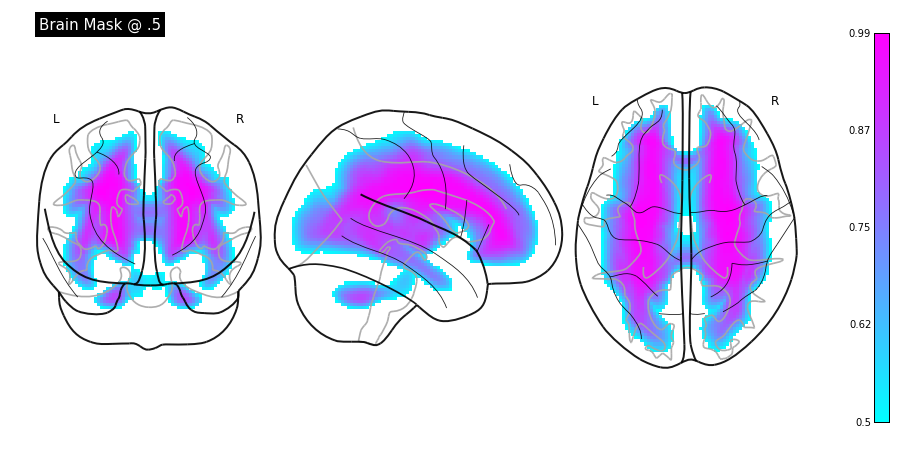

In [5]:
fig = figure(figsize=(12,6))
plot_glass_brain(nib.load(mask_path),
                 threshold=.5,
                 colorbar=True,
                 title='Brain Mask @ .5',
                 cmap=plt.cm.cool,alpha=.9,
                 figure = fig
                )
plt.show()

#Loading data

In [6]:
# grabbing dmean and fa for testing 
dfa = load_db(base_dir,classes).ix[['dmean','kmean','fa']]
dfa

OSError: [Errno 2] No such file or directory: '/home/nick/Desktop/dki_stuff/modalities/'

# applying mask

In [7]:
## applying mask to matrices
# masked_matrices = mask_dataframe(dfa,mask_path)
masked_matrices = pd.read_pickle('/home/desistonv/masked_matrices.pickle')
masked_matrices

,cons,pats
dmean,"[[0.900367, 0.929843, 0.892926, 0.920383, 0.87...","[[0.947932, 0.997482, 0.966199, 0.994236, 0.93..."
fa,"[[0.193831, 0.233026, 0.21176, 0.266958, 0.191...","[[0.159587, 0.201227, 0.169772, 0.196879, 0.16..."
kmean,"[[0.890155, 0.896358, 0.915954, 0.90995, 0.946...","[[0.907448, 0.916198, 0.943497, 0.947185, 0.92..."


# z-scoring and mag div

In [39]:
results_df = pd.DataFrame(columns=['results_mean','alpha','C','gamma','n_features','mode'])
results_df

,results_mean,alpha,C,gamma,n_features,mode


# Running Lasso FC outside GridSearch Dmean
* To change modality, set mode below 
 * variable mode must be a list, can contain multiple modalities 
 
We obtained our best results here with : 
<table style="width:40%">
  <tr>
    <td><b>Modality</b></td>
    <td><b>Alpha</b></td> 
    <td><b>Gamma</b></td>
  </tr>
  <tr>
    <td>dmean</td>
    <td>.01</td> 
    <td>8.286</td>
  </tr>
    <tr>
    <td>kmean</td>
    <td>.01</td> 
    <td>15</td>
  </tr>
    <tr>
    <td>fa</td>
    <td>.00001</td> 
    <td>0.15</td>
  </tr>
      <tr>
    <td>dmean & kmean</td>
    <td>0.0001</td> 
    <td>1</td>
  </tr>    <tr>
    <td>dmean & fa</td>
    <td>.001</td> 
    <td>1</td>
    
  </tr>
      <tr>
    <td>kmean & fa</td>
    <td>0.0001</td> 
    <td>1</td>
    
  </tr>
        <tr>
    <td>all 3</td>
    <td>0.00001</td> 
    <td>1</td>
    
  </tr>
  
</table>


In [9]:
mode = ['dmean']
mat = build_matrix(masked_matrices,mode)

In [46]:
y_labels_vector = build_y(masked_matrices,mode)
x_input = zscore_mag_div_matrix(mat)
print x_input.shape
nonZ =  np.count_nonzero(x_input)
print nonZ

Y label vector is 68 elements, with 36 False and 32 True

y_labels_vector.shape : (68,)       ( Should be (n_samples,) )
 0% done
 0% done
 0% done
 0% done
 0% done
 0% done
 0% done
 0% done
 0% done
(68, 435702)
29627736


# Search Range

In [40]:
alpha_range = [.01,.001,.0001]
gamma_range = [.1,1,8]

In [41]:
n_cpus = -1
print x_input.shape


for al in alpha_range:
    
    print 'running alpha : {}'.format(al)
    
    x_input_to_svc,_ = lasso_feature_selection(np.copy(x_input), y_labels_vector, al)

    if np.count_nonzero(x_input_to_svc) > 0:
        svc_pipe = Pipeline([('svc', SVC(C=1))])

        gridsearcher = GridSearchCV(svc_pipe, 
                            param_grid=dict(svc__gamma=gamma_range),
                            cv= StratifiedKFold(y_labels_vector,6),
                            verbose=1,
                            n_jobs=n_cpus
                           )
        gridsearcher.fit(x_input_to_svc,y_labels_vector)
        for g in gridsearcher.grid_scores_:
            gg =  [g[1],al,1,g[0]['svc__gamma'],np.count_nonzero(x_input_to_svc)/len(y_labels_vector),mode]
            results_df.loc[ len(results_df) ] = gg
    else:
        print '0 features selected at alpha {} ; not running'.format(al)






(68, 435702)
running alpha : 0.01
Weights Shape : (435702,)
24 positive coefficients @ alpha = 0.01
24 positive coefficients @ alpha = 0.01
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    8.3s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   1 out of  18 | elapsed:   10.7s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   12.6s finished


running alpha : 0.001
Weights Shape : (435702,)
38 positive coefficients @ alpha = 0.001
38 positive coefficients @ alpha = 0.001
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    9.9s remaining:   15.6s
[Parallel(n_jobs=-1)]: Done   1 out of  18 | elapsed:   10.6s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   13.2s finished


running alpha : 0.0001
Weights Shape : (435702,)
45 positive coefficients @ alpha = 0.0001
45 positive coefficients @ alpha = 0.0001
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    9.6s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done   1 out of  18 | elapsed:   10.5s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   13.1s finished


# Dmean Results

In [42]:
results_df.sort('results_mean',ascending=False).head(5)

,results_mean,alpha,C,gamma,n_features,mode
2,0.926471,0.0100,1,8.0,24,[dmean]
1,0.897059,0.0100,1,1.0,24,[dmean]
0,0.882353,0.0100,1,0.1,24,[dmean]
8,0.882353,0.0001,1,8.0,45,[dmean]
5,0.867647,0.0010,1,8.0,38,[dmean]


Max Performance : 0.92647


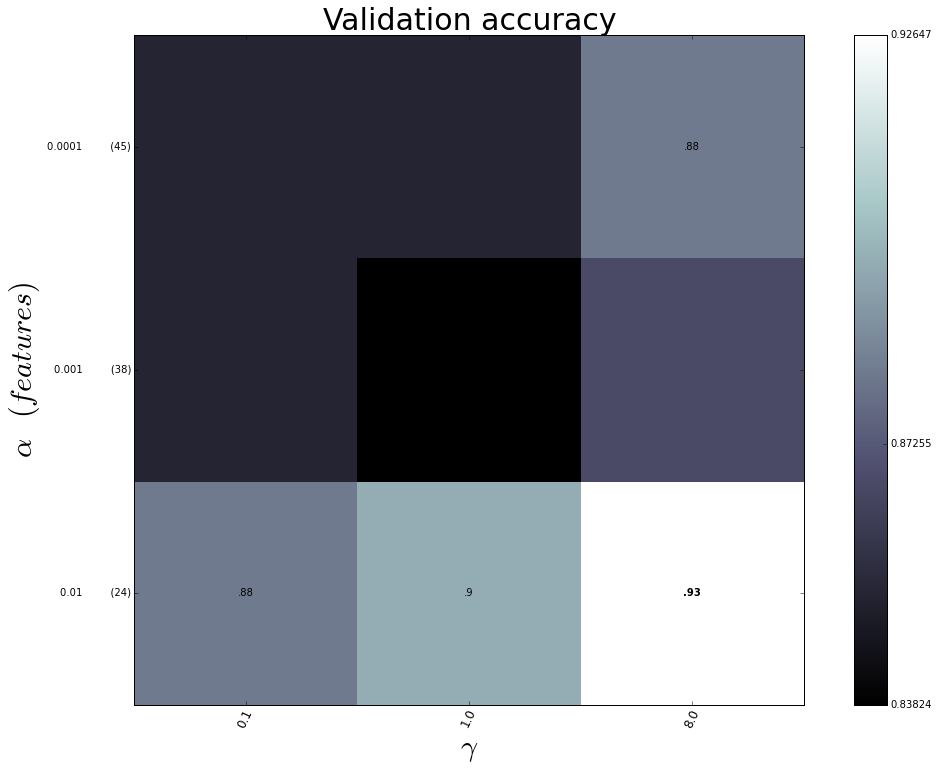

In [47]:
imshow_data(results_df)

# Visualizing feature selection for best Lasso score

In [48]:
resampled_mask = create_mask(nib.load('/home/desistonv/white.nii'),
                   nib.load('/home/desistonv/dmeanPAT100.nii')
                  )


In [49]:
_,coefs = lasso_feature_selection(np.copy(x_input),y_labels_vector,.01)

Weights Shape : (435702,)
24 positive coefficients @ alpha = 0.01
24 positive coefficients @ alpha = 0.01


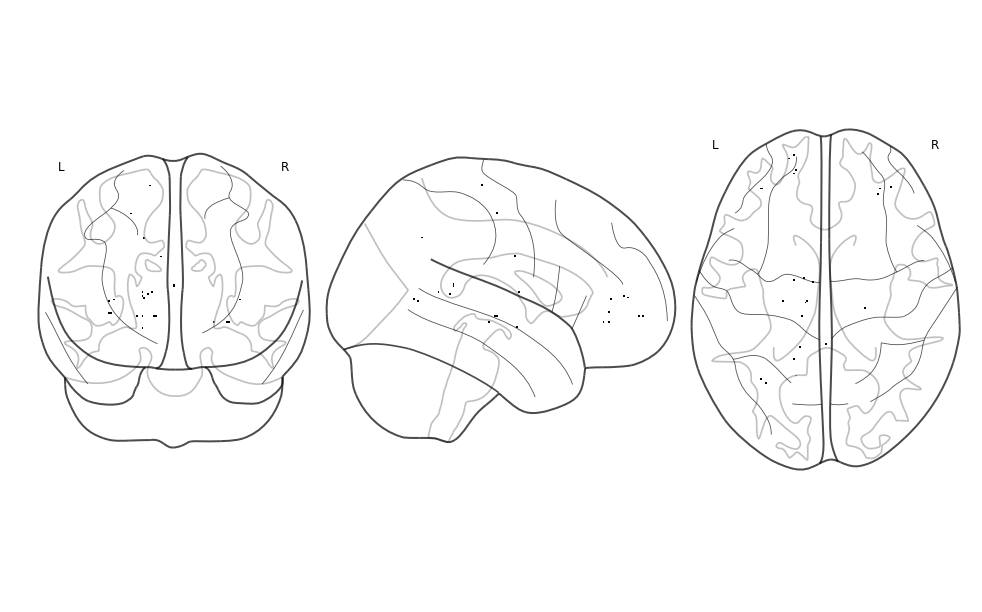

In [51]:
fig = figure(figsize=(13,8))

plot_glass_brain(coefs_mask(coefs,resampled_mask),cmap='hot',figure=fig)
show()

# adding Lasso to the cross-validation

In [53]:
alpha_range = [.01,.001,.0001]
gamma_range = [.1,1,8]

score_matrix = np.zeros((6,len(alpha_range),len(gamma_range)))
cv = StratifiedKFold(y_labels_vector,6)
y = y_labels_vector
X = np.copy(x_input)
fold = 0
for train, test in cv:
    y_test = y[test]
    X_test = X[test]
    
    y_train = y[train]
    X_train = X[train]
    for alpha_it, alpha in enumerate(alpha_range):
        ls = Lasso(alpha,copy_X=True,max_iter=1e5)
        ls.fit(X_train,y_train)
        w = MakeBinary(ls.coef_)
        np.nonzero(w)
        print '{} features selected @ alpha : {}'.format(np.count_nonzero(w),alpha)

        X_train_w = X_train * w
        X_test_w = X_test * w 

        for gamma_it ,gamma in enumerate(gamma_range):
            svc = SVC(gamma = gamma)
            svc.fit(X_train_w,y_train)
            y_test_pred = svc.predict( X_test_w )
            score = f1_score( y_test , y_test_pred )
            score_matrix[ fold, alpha_it, gamma_it ] = score
            print '| fold : {:>6} | alpha : {:>6} | gamma : {:>6} |  score : {:>5} % '.format(fold,alpha,gamma,round(score*100,2))
    fold += 1

#    scoresss = Parallel(n_jobs=1,verbose=50)(
#                     delayed(do_cv)(train,test) for train, test in cv)

24 features selected @ alpha : 0.01
| fold :      0 | alpha :   0.01 | gamma :    0.1 |  score : 90.91 % 
| fold :      0 | alpha :   0.01 | gamma :      1 |  score : 92.31 % 
| fold :      0 | alpha :   0.01 | gamma :      8 |  score : 92.31 % 
array-check : 29627736
32 features selected @ alpha : 0.001
| fold :      0 | alpha :  0.001 | gamma :    0.1 |  score : 90.91 % 
| fold :      0 | alpha :  0.001 | gamma :      1 |  score : 83.33 % 
| fold :      0 | alpha :  0.001 | gamma :      8 |  score : 85.71 % 
array-check : 29627736
36 features selected @ alpha : 0.0001
| fold :      0 | alpha : 0.0001 | gamma :    0.1 |  score : 90.91 % 
| fold :      0 | alpha : 0.0001 | gamma :      1 |  score : 83.33 % 
| fold :      0 | alpha : 0.0001 | gamma :      8 |  score : 92.31 % 
array-check : 29627736
22 features selected @ alpha : 0.01
| fold :      1 | alpha :   0.01 | gamma :    0.1 |  score : 44.44 % 
| fold :      1 | alpha :   0.01 | gamma :      1 |  score :  60.0 % 
| fold :      

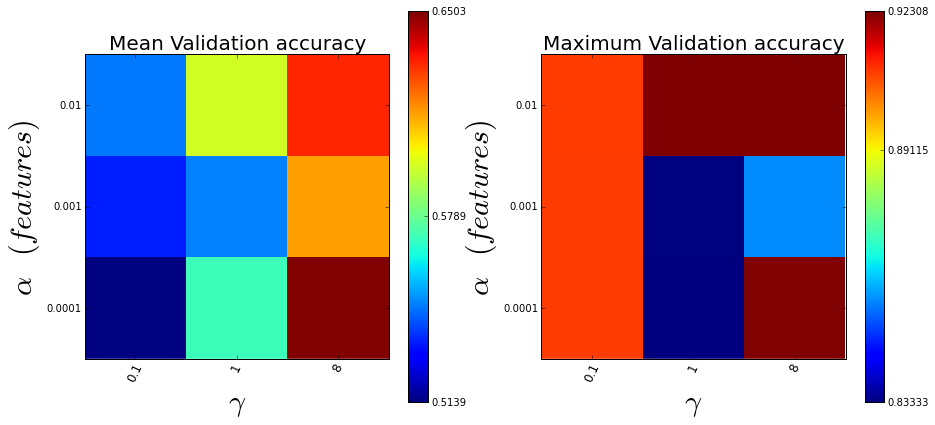

In [72]:
rcParams['axes.titlesize']=  20
plt.figure(figsize=(15,7))
plt.subplot(121)
mean_scores = np.mean(score_matrix,axis=0)
cax = imshow(mean_scores,interpolation='none')
cbar = plt.colorbar(cax, ticks=[np.min(mean_scores), np.mean(mean_scores), np.max(mean_scores)])
plt.xticks(np.arange(len(gamma_range)),gamma_range, rotation=65)
plt.yticks(np.arange(len(alpha_range)),alpha_range)
plt.ylabel(r'$\alpha\;(features)$')
plt.title('Mean Validation accuracy')
plt.xlabel(r'$\gamma$')
plt.subplot(122)

max_scores = np.max(score_matrix,axis=0)
cax = imshow(max_scores,interpolation='none')
cbar = plt.colorbar(cax, ticks=[np.min(max_scores), np.mean(max_scores), np.max(max_scores)])
plt.xticks(np.arange(len(gamma_range)),gamma_range, rotation=65)
plt.yticks(np.arange(len(alpha_range)),alpha_range)
plt.ylabel(r'$\alpha\;(features)$')
plt.title('Maximum Validation accuracy')
plt.xlabel(r'$\gamma$')
plt.show()

In [55]:
coeffs = np.zeros(X.shape[1])
# print coeffs.shape
selected_voxels=[]
cv = StratifiedKFold(y,6)
for train, val in cv:
    y_val = y[val]
    X_val = X[val]
    
    y_train = y[train]
    X_train = X[train]

    ls = Lasso(.001,copy_X=True)
    ls.fit(X_train,y_train)
    w = MakeBinary(ls.coef_)
    coeffs[np.nonzero(w)] += 1
    print np.count_nonzero(w)
    selected_voxels.append(np.nonzero(w))


31
32
36
35
45
41


/home/desistonv/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


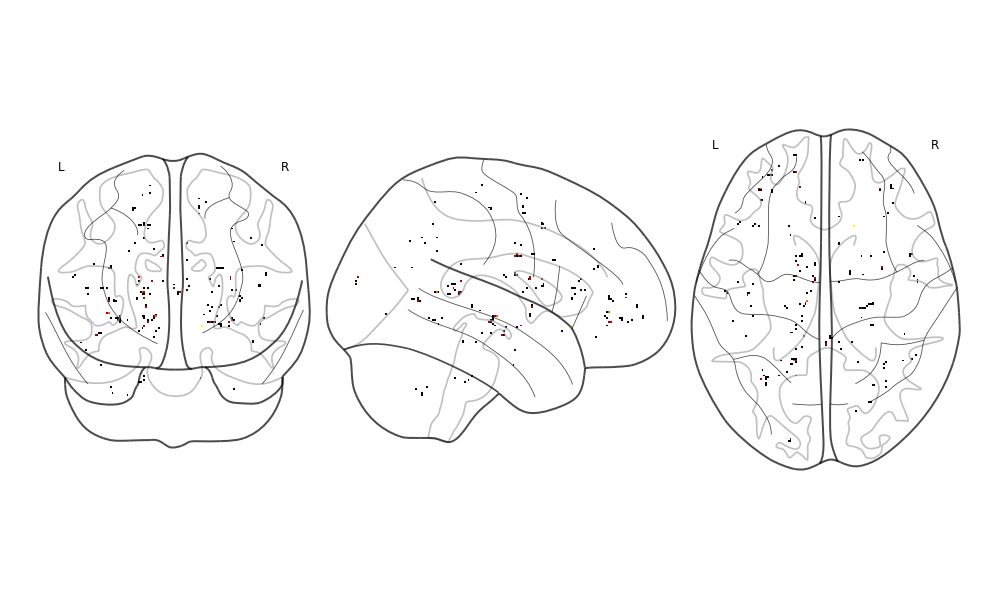

In [73]:
fig = figure(figsize=(13,8))
plot_glass_brain(coefs_mask(coeffs,resampled_mask),cmap='hot',figure=fig)

show()

# 2-nested search

In [74]:
score_matrix = np.zeros(6)


cv = StratifiedKFold(y,6)
def do_cv(train,test):
    y_test = y[test]
    X_test = X[test]
    
    y_train = y[train]
    X_train = X[train]
    params = []
    cv2 = StratifiedKFold(y_train,6)
    for train2, test2 in cv2:
        y_train2 = y_train[train2]
        X_train2  = X_train[train2]

        y_test2 = y_train[test2]
        X_test2 = X_train[test2]

        for alpha_it, alpha in enumerate(alpha_range):
                ls = Lasso(alpha,copy_X=True,max_iter=1e5)
                ls.fit(X_train2,y_train2)
                w = MakeBinary(ls.coef_)
                np.nonzero(w)
                print '{} features selected @ alpha : {}'.format(np.count_nonzero(w),alpha)

                X_train_w = X_train2 * w
                X_test_w = X_test2 * w 

                for gamma_it ,gamma in enumerate(gamma_range):
                    svc = SVC(gamma = gamma)
                    svc.fit(X_train_w,y_train2)
                    y_test_pred = svc.predict( X_test_w )
                    score = f1_score( y_test2 , y_test_pred )
                    #score_matrix[ fold, alpha_it, gamma_it ] = score
                    params.append( (score,alpha,gamma) )
#                     print '| alpha : {:>6} | gamma : {:>6} |  score : {:>5} % '.format(alpha,gamma,round(score*100,2))
    params = sorted(params,key = lambda x: x[0])[::-1][0]
    print params
    ls = Lasso(params[1],copy_X=True,max_iter=1e5)
    ls.fit(X_train,y_train)
    w = MakeBinary(ls.coef_)
    X_train_w = X_train * w
    X_test_w = X_test * w
    svc = SVC(gamma = params[2])
    svc.fit(X_train_w,y_train)
    y_test_pred = svc.predict(X_test_w)
    return ( f1_score(y_test,y_test_pred) , params ,w)
    

In [77]:
from joblib import Parallel, delayed
# parallel function
## save paths of masked data
scoresss = Parallel(n_jobs=-1,verbose=1)(
                    delayed(do_cv)(train,test) for train, test in cv)
   

[Parallel(n_jobs=-1)]: Done   1 out of   6 | elapsed: 28.6min remaining: 142.9min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 29.9min finished
/home/desistonv/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/desistonv/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/desistonv/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


21 features selected @ alpha : 0.01
15 features selected @ alpha : 0.01
15 features selected @ alpha : 0.01
14 features selected @ alpha : 0.01
24 features selected @ alpha : 0.01
17 features selected @ alpha : 0.01
27 features selected @ alpha : 0.00129 features selected @ alpha : 0.00123 features selected @ alpha : 0.00124 features selected @ alpha : 0.00128 features selected @ alpha : 0.00127 features selected @ alpha : 0.001





32 features selected @ alpha : 0.000134 features selected @ alpha : 0.000127 features selected @ alpha : 0.000131 features selected @ alpha : 0.000135 features selected @ alpha : 0.000128 features selected @ alpha : 0.0001





26 features selected @ alpha : 0.0120 features selected @ alpha : 0.0122 features selected @ alpha : 0.0118 features selected @ alpha : 0.0117 features selected @ alpha : 0.0118 features selected @ alpha : 0.01





36 features selected @ alpha : 0.00128 features selected @ alpha : 0.00127 features selected @ alpha : 0.00132 feature

In [79]:
for s in scoresss:
    print '| full score : {:>15} | inner score {:>15} | alpha : {:>15} | gamma : {:>15} |'.format(s[0],*s[1])
print '\n| mean score : {:>5} |'.format(np.mean([s[0] for s in scoresss]))

| full score :  0.909090909091 | inner score  0.857142857143 | alpha :          0.0001 | gamma :             0.1 |
| full score :             0.6 | inner score             1.0 | alpha :          0.0001 | gamma :               8 |
| full score :  0.285714285714 | inner score  0.888888888889 | alpha :            0.01 | gamma :             0.1 |
| full score :  0.666666666667 | inner score  0.909090909091 | alpha :          0.0001 | gamma :               8 |
| full score :             0.5 | inner score  0.888888888889 | alpha :          0.0001 | gamma :             0.1 |
| full score :  0.545454545455 | inner score  0.909090909091 | alpha :          0.0001 | gamma :               8 |

| mean score : 0.584487734488 |


In [88]:
s = [np.nonzero(s[2]) for s in scoresss]
s = [item for sublist in s for item in sublist]
s = [item for sublist in s for item in sublist] 

print 'mean features selected : {}'.format(len(s) /6)
print 'unique features selected : {}'.format(len(np.unique(s)))

mean features selected : 39
unique features selected : 201


In [81]:
coefs = [s[2] for s in scoresss]
zzz = np.zeros(len(coefs[0]))
for c in coefs:
    zzz += c

Populating the interactive namespace from numpy and matplotlib


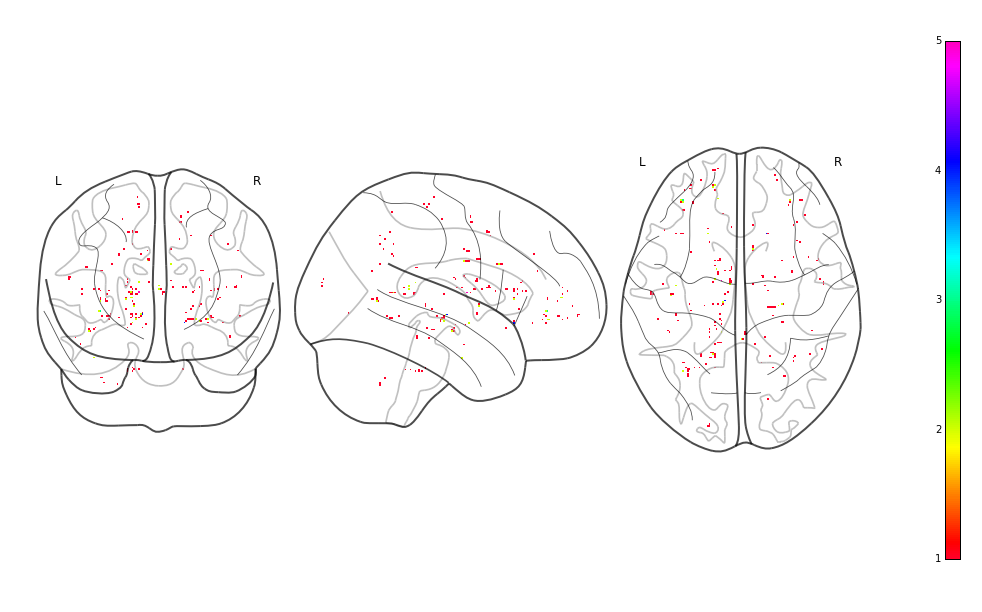

In [86]:
%pylab inline
fig = figure(figsize=(13,8))
plot_glass_brain(coefs_mask(zzz,resampled_mask),cmap='gist_rainbow',figure=fig,colorbar=True)
show()

In [89]:
print count_nonzero(x_input)

29627736
